# Data Madness
## Group idk

### authors:
* Simon Garland
* PierrePaul Charbonnier
* Filip Straka

Department of Advanced Computing Sciences
Maastricht University
March 2024

Let's begin with extracting the data from the ZIP files (they'll grow tremendously)

In [ ]:
import os.path

# NB: im doing it on a small fraction of the data now to prevent my laptop from blowing up ever so nicely

## imports ##

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

In [ ]:
# define all possible files
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
years = ["21", "22", "23", "24"]
modes = ["standard", "rapid", "blitz"]

In [ ]:
for month in months:
    for mode in modes:
        #for year in years:
        year = "24"
        path = '../data_zipped/'+mode+"_"+month+year+"frl_xml.zip"
        if os.path.exists(path):
            with zipfile.ZipFile(path, 'r') as zip_ref:
                zip_ref.extractall('../data_unzipped')

In [ ]:
lst = []
for month in months:
    for mode in modes:
        year = "24"
        #for year in years:
        path = '../data_unzipped/'+mode+"_"+month+year+"frl_xml.xml"
        if os.path.exists('../data_unzipped/'+mode+"_"+month+year+"frl_xml.xml"):
            df = pd.read_xml(path)
            df.head(10)
            lst.append(df)

Now that we have the 

(array([1.1803e+04, 1.4349e+04, 1.5924e+04, 1.6556e+04, 1.7378e+04,
        1.7192e+04, 1.7685e+04, 1.7442e+04, 1.8283e+04, 1.8261e+04,
        1.8414e+04, 1.8823e+04, 1.8831e+04, 1.9177e+04, 1.8480e+04,
        1.8813e+04, 1.8252e+04, 1.7693e+04, 1.6636e+04, 1.6109e+04,
        1.5160e+04, 1.3686e+04, 1.3698e+04, 1.1848e+04, 1.0235e+04,
        8.0710e+03, 6.7760e+03, 4.8790e+03, 3.6490e+03, 2.2400e+03,
        1.6960e+03, 1.0020e+03, 5.6000e+02, 3.4700e+02, 2.0900e+02,
        1.2100e+02, 6.0000e+01, 2.9000e+01, 1.4000e+01, 4.0000e+00]),
 array([1001.   , 1046.725, 1092.45 , 1138.175, 1183.9  , 1229.625,
        1275.35 , 1321.075, 1366.8  , 1412.525, 1458.25 , 1503.975,
        1549.7  , 1595.425, 1641.15 , 1686.875, 1732.6  , 1778.325,
        1824.05 , 1869.775, 1915.5  , 1961.225, 2006.95 , 2052.675,
        2098.4  , 2144.125, 2189.85 , 2235.575, 2281.3  , 2327.025,
        2372.75 , 2418.475, 2464.2  , 2509.925, 2555.65 , 2601.375,
        2647.1  , 2692.825, 2738.55 , 2784.275

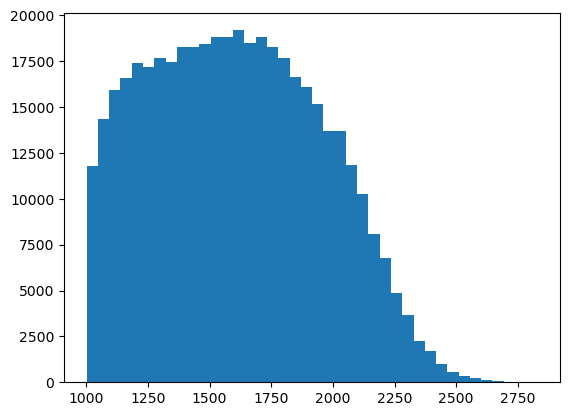

In [35]:
plt.hist(lst[0]["rating"], bins=40)

(array([9.9650e+03, 1.3306e+04, 1.4951e+04, 1.5577e+04, 1.6010e+04,
        1.5931e+04, 1.5452e+04, 1.4896e+04, 1.4721e+04, 1.4468e+04,
        1.3886e+04, 1.3559e+04, 1.3496e+04, 1.2883e+04, 1.1860e+04,
        1.1883e+04, 1.0973e+04, 1.0130e+04, 9.2510e+03, 8.5760e+03,
        7.6170e+03, 6.5610e+03, 5.9520e+03, 4.9580e+03, 4.0230e+03,
        3.1000e+03, 2.6730e+03, 1.9210e+03, 1.4300e+03, 1.0380e+03,
        7.5000e+02, 5.6900e+02, 3.4900e+02, 2.5800e+02, 1.2900e+02,
        1.0300e+02, 3.6000e+01, 2.1000e+01, 9.0000e+00, 2.0000e+00]),
 array([1001.   , 1046.725, 1092.45 , 1138.175, 1183.9  , 1229.625,
        1275.35 , 1321.075, 1366.8  , 1412.525, 1458.25 , 1503.975,
        1549.7  , 1595.425, 1641.15 , 1686.875, 1732.6  , 1778.325,
        1824.05 , 1869.775, 1915.5  , 1961.225, 2006.95 , 2052.675,
        2098.4  , 2144.125, 2189.85 , 2235.575, 2281.3  , 2327.025,
        2372.75 , 2418.475, 2464.2  , 2509.925, 2555.65 , 2601.375,
        2647.1  , 2692.825, 2738.55 , 2784.275

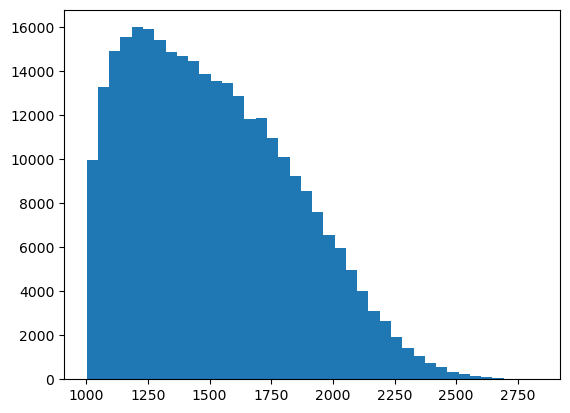

In [36]:
plt.hist(lst[1]["rating"], bins=40)

(array([4.517e+03, 6.174e+03, 7.429e+03, 8.296e+03, 8.775e+03, 9.010e+03,
        9.317e+03, 9.513e+03, 9.922e+03, 9.663e+03, 9.680e+03, 9.710e+03,
        9.707e+03, 9.586e+03, 9.670e+03, 9.220e+03, 9.213e+03, 8.700e+03,
        8.066e+03, 7.387e+03, 6.641e+03, 6.032e+03, 5.087e+03, 4.305e+03,
        3.459e+03, 2.741e+03, 2.139e+03, 1.517e+03, 1.080e+03, 7.990e+02,
        5.230e+02, 3.720e+02, 2.820e+02, 1.560e+02, 7.900e+01, 3.900e+01,
        2.100e+01, 8.000e+00, 3.000e+00, 3.000e+00]),
 array([1001.   , 1048.125, 1095.25 , 1142.375, 1189.5  , 1236.625,
        1283.75 , 1330.875, 1378.   , 1425.125, 1472.25 , 1519.375,
        1566.5  , 1613.625, 1660.75 , 1707.875, 1755.   , 1802.125,
        1849.25 , 1896.375, 1943.5  , 1990.625, 2037.75 , 2084.875,
        2132.   , 2179.125, 2226.25 , 2273.375, 2320.5  , 2367.625,
        2414.75 , 2461.875, 2509.   , 2556.125, 2603.25 , 2650.375,
        2697.5  , 2744.625, 2791.75 , 2838.875, 2886.   ]),
 <BarContainer object of 40 artist

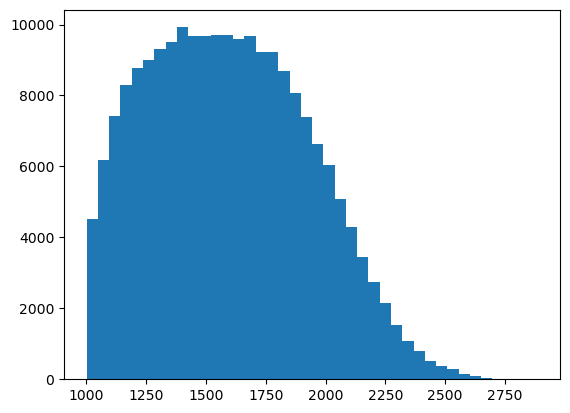

In [37]:
plt.hist(lst[2]["rating"], bins=40)

In [38]:
lst[0].head(10)

,fideid,name,country,sex,title,w_title,o_title,foa_title,rating,games,k,birthday,flag
0,10245154,"A B M Jobair, Hossain",BAN,M,None,None,None,None,1583,0,40,1998.0,None
1,25121731,A C J John,IND,M,None,None,None,None,1063,0,40,1987.0,i
2,35077023,A Chakravarthy,IND,M,None,None,None,None,1151,0,40,1986.0,i
3,10207538,"A E M, Doshtagir",BAN,M,None,None,None,None,1840,0,40,1974.0,i
4,10680810,"A hamed Ashraf, Abdallah",EGY,M,None,None,None,None,1728,0,40,2001.0,i
5,5716365,"A Hamid, Harman",MAS,M,None,None,None,None,1325,0,40,1970.0,i
6,10206612,"A K M, Sourab",BAN,M,None,None,None,None,1598,0,20,NaN,i
7,5045886,"A K, Kalshyan",IND,M,None,None,None,None,1671,0,20,1964.0,i
8,8605360,"A La, Teng Hua",CHN,F,None,None,None,None,1915,0,40,1993.0,wi
9,10238387,"A Q M Salahuddin, Khan",BAN,M,None,None,None,None,1491,0,40,1977.0,None
